# "Modello di Axelrod"
> "Implementazione del modello e analisi delle sue proprietà "

In questa relazione mi occuperò di studiare numericamente e, in parte, analiticiamente un modello Agent-Based di Cultural Dynamics, ovvero un'estensione vettoriale della dinamica delle opinioni: il modello di Axelrod.


# Introduzione

Negli ultimi anni si è iniziato a studiare i fenomeni collettivi, emergenti da un insieme di individui, attraverso un formalismo matematico afferente per lo più alla fisica statistica, scienza delle reti e più in generale ai sistemi complessi. Nonostante nella storia della scienza, ed in particolare della fisica, ci siano esempi di studiosi che hanno applicato modelli quantitativi a problemi che riguardavano la sociologia, solo negli ultimi anni si è formata una corrente di studi incentrata appunto sul descrivere il comportamento collettivo umano attraverso modelli matematici: la sociofisica. 

Uno dei primi campi di ricerca in questo ambito è stato la dinamica delle opinioni, in cui si cerca di descrivere come una opinione appunto possa essere trasmessa tra vari individui appartenenti ad una rete sociale, cercando di studiarne la dinamica e gli effetti finali "macroscopici", quali la formazione di un consenso unanime (problema simile a quello della transizione ferromagnetica) o la formazione di cluster di opinioni.
Uno dei modelli più importanti di dinamica delle opinioni è il Voter Model.
#### descrivere voter model
Il modello in esame in questa relazione può essere visto, almeno nella sua versione originale, come un insieme di Voter Model accoppiati. Esiste quindi un numero $F$ di possibili diversi argomenti (features culturali) per i quali un individuo può avere $Q$ diverse opinioni. Esempi di features possono essere “linguaggio, arte, **norme tecniche** e regole sociali” [1], *i quali valori delle opinioni possono cambiare solo attraverso un'influenza sociale, quindi in questo modello non verrano considerati gli effetti di istituzioni centrali e mass media, ma la dinamica avverrà solamente tra individui il che porterà la rete sociale ad autorganizzarsi.*

Le proprietà chiave di questo modello sono principalmente due:
1. Individui che condividono un maggior numero di features hanno maggiore probabilità di interazione (homophily)
2. Ogni interazione aumenta il numero di features che i due soggetti hanno in comune.



# Algoritmo e implementazione

Il modello è definito su un reticolo quadrato di lato $L$, in cui il numero totale degli individui è dunque $N=L^2$.
Su ogni sito $i$ è definito un set di $F$ features culturali $q_{i,f}$, numeri interi che vanno da 0 a $Q$ per ogni $f$ che va da 0 a $F$. Nello stato iniziale tutti i valori $q_{i,f}$ sono estratti in maniera casuale da una distribuzione uniforme. 

Ad ogni passo temporale viene scelto un sito $i$ random ed un suo primo vicino $j$ sempre random. Viene dunque estratta in maniera casuale una feature $f$ e se risulta che $q_{i,f} \neq q_{j,f}$ si prosegue col passo temporale successivo senza apportare modifiche, altrimenti se le due features risultano uguali, si estrae a sorte una seconda features $f'$ tra le features che risultano diverse e la prima si impone uguale alla seconda: $q_{i,f'} = q_{j,f'}$.

L'algoritmo è dunque formato da un ciclo di step elementari del tipo:

1. Estrazione random di $i$ tra 0 ed $N$
2. Estrazione random di $j$ tra i primi vicini di $i$
3. Estrazione random di $f$ tra 0 ed $F$
4. Se $q_{i,f} \neq q_{j,f}$:
    1. Step temporale successivo
5. Altrimenti se $q_{i,f} = q_{j,f}$:
    1. Estrazione random di $f'$ tale che $q_{i,f'} \neq q_{j,f'}$
    2. Si impone $q_{i,f'} = q_{j,f'}$
    3. Step temporale successivo
    
    
Possiamo notare che nel caso in cui ogni coppia possibile di primi vicini condivida o tutte le features o nessuna, la dinamica del sistema si arresta. Tali stati prendono il nome Absorbing States che per definizione sono gli stati finali dell'evoluzione dinamica del sistema. Possono esistere vari tipi di Absorbing States come vedremo, che possono essere più o meno ordinati. Per sistemi di dimensione finita può essere verificato che la dinamica raggiunge sempre uno stato Absorbing in un tempo finito. 

Per costruzione del tipo di interazione, l'evoluzione dinamica tende ad ordinare il sistema e a diminuire il numero dei differenti valori di $q$ relativi a ciascuna features $f$. È intuitivo che per bassi valori di $Q$ il sistema già inizialmente si trovi in uno stato piuttosto omogeneo se confrontato con sistemi con $Q>>1$  per cui la distribuzione dei valori di $q$ è molto più larga, perciò ci si aspetta una maggiore facilità per i casi con bassi valori di $Q$ di raggiungere un consenso, fenomeno verificato come vedremo dalle simulazioni.

Di seguito procederò con l'implementazione dell'algoritmo. Per farlo dovrò prima importare le librerie necessarie, in questo caso solamente NumPy per i calcoli matriciali e Pyplot di Matplotlib per i grafici:

In [1]:
#collapse

import numpy as np
import matplotlib.pyplot as plt

Dovrò inoltre definire qualche nuova funzione:

+ Una funzione che definisce lo stato iniziale di un sistema di $N$ elementi aventi $F$ features, con valori $q_{i,f}$ interi estratti in maniera casuale da una distribuzione uniforme tra 0 e $Q$:

In [2]:
#collapse

def iniState(N,F,Q):
    
    return np.random.randint(Q,size=(N,F))

+ Una funzione che dato un sito $a$ del reticolo quadrato restituisce un sito $b$ primo vicino di $a$ estratto da una distribuzione uniforme tra 1 e 4:

In [3]:
#collapse

def chooseBlat(a):
    
    b1=np.random.randint(D*2)
    if b1==0: 
        if (a+1)%L==0:
            b=a+1-L
        else: b=a+1
    elif b1==1:
        if a%L==0:
            b=a-1+L
        else: b=a-1
    elif b1==2: b=a+L
    else: b=a-L
        
    return b%N

+ Una funzione che calcola il numero di collegamenti attivi nel sistema. Per collegamento attivo si intende una coppia di individui primi vicini che condividono lo stesso valore di almeno una features, ma non di tutte le features. Questa funzione ci servirà come parametro di arresto, infatti quando il numero di collegamenti attivi è uguale a zero non è più possibile una variazione dei $q_{i,f}$ di nessun elemento del sistema, quindi la dinamica si arresta e lo stato raggiunto è per definizione un Absorbing State. Inoltre questa funzione ci servirà in seguito per studiare proprio la dinamica del sistema.

In [4]:
#collapse

def calcAct(ind):
    Act=np.zeros((D*N,2),dtype=int)-1
    for ai in range(N):
        bi=Bdx(ai)
        if (ind[ai]==ind[bi]).any() and (ind[ai]!=ind[bi]).any():
            Act[D*ai]=np.array([ai,bi])

        ci=Bdw(ai)
        if(ind[ai]==ind[ci]).any() and (ind[ai]!=ind[ci]).any():
            Act[D*ai+1]=np.array([ai,ci])

    return (Act[:,0]+1).nonzero()[0].size/(N*D)
        
def Bdx(a):
    if (a+1)%L==0:
        b=a+1-L
    else: b=a+1
    return np.int(b)

def Bdw(a):
    b=a+L
    return np.int(b%N)

A questo punto è possibile procedere con l'implementazione dell'algoritmo: il codice seguente restituisce in output un vettore *ind* contenente tutte le varie configurazioni per ogni passo temporale. Ogni componente del vettore *ind* è composto a sua volta da un vettore ad $N$ componenti che rappresenta la configurazione del sistema ad un certo tempo $t$. Infatti ognuna delle $N$ componenti è formato a sua volta (e per l'ultima volta) da un vettore di dimensione $F$ che contiene i valori $q_{i,f}$ delle features relative all'individuo $i$. 

Nell'implementazione è stato più utile considerare come passo temporale, in realtà, un numero di passi dell'algoritmo pari al numero $N$ di elementi che compongono il sistema. In pratica si misura il tempo in unità del numero di elementi. 

In [ ]:
#collapse

# Dichiarazioni

L=20        # taglia del reticolo
D=2         # dimensione spaziale
N=L**D      # numero totale di elementi del sistema

F=10        # numero di features
Q=30        # valore massimo che può assumere una feature     MODIFICARE QUESTO PER OTTERENERE DINAMICHE DIVERSE

TN=100000   # numero massimo di time steps (sovrastimato)
TC=TN-1     # inizializzazione del tempo critico per cui la dinamica si arresta

ind=np.zeros((TN+1,N,F),dtype=int)  # inizializzazione del vettore delle configurazioni
ind[0]=iniState(N,F,Q)              # configurazione iniziale
indt=np.zeros((N,F),dtype=int)      # configurazione temporanea
nA=np.zeros(TN)                     # vettore del numero di collegamenti attivi, nel tempo

for tnn in np.arange(TN):           
    
    indt=ind[tnn].copy()
    
    for tn in np.arange(N):
        a=np.random.randint(N)
        b=chooseBlat(a)

        if (indt[a]!=indt[b]).any() and (indt[a]==indt[b]).any():
            c=np.random.randint(F)
            if indt[a,c]==indt[b,c]:
                dd=np.random.randint(F)
                for Fi in range(F):
                    d=(dd+Fi)%F
                    if indt[a,d]!=indt[b,d]:
                        indt[a,d]=indt[b,d].copy()
                        break
    
    nA[tnn]=calcAct(ind[tnn])

    if nA[tnn]==0:
        TC=tnn
        break

    ind[tnn+1]=indt.copy()
    
    

Per rappresentare graficamente l'evoluzione nel tempo delle configurazioni del sistema, quindi in pratica l'evoluzione delle componenti di *ind*, è stato necessario manipolare un po' il vettore per renderlo quadrato ed animarlo attraverso delle funzioni di matplotlib.

In [ ]:
#collapse
%matplotlib widget
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

aa=np.zeros((TN,L,L),dtype=int)
aa=np.reshape(ind[:,:,0],(TN+1,L,L))

animation_type = 'pcolor'

fig, ax = plt.subplots(figsize=(4, 4))
ax.set(xlim=(0, L-1), ylim=(0, L-1))          #aggiungere titolo
x=np.arange(L)
y=np.arange(L)
t=np.arange(TC)
X,Y,T=np.meshgrid(x, y, t)

        
if animation_type == 'pcolor':
    cax = ax.pcolormesh(x, y, aa[0,:-1, :-1], cmap='jet')
    #fig.colorbar(cax)
def animate(i):
    cax.set_array(aa[i,:-1, :-1].flatten())
    
anim = FuncAnimation(fig, animate, frames=len(t)-1, repeat=False, interval=10)
fig.show()

print("Tempo critico = "+str(TC))

Per motivi di programmazione della pagina web non è stato possibile inserire le animazioni di matplotlib. Il codice sopra è funzionante e se fatto girare restituirà una delle animazioni sotto, che sono state invece pubblicate su YouTube per poter essere visualizzate in questa pagina.

> youtube: https://youtu.be/mKio9pir8Dk

# Studio degli stati finali: Absorbing States

La prima parte di questa relazione andrà a presentare i dati relativi agli studi effettuati appunto sulle proprietà degli Absorbing States finali. L'osservabile che considereremo come parametro d'ordine in questa parte è una sorta di densità di magnetizzazione, $⟨s_{max}⟩$, ovvero il numero di siti che presentano lo stesso valore $q$ di una certa feature $f$ per cui questa grandezza risulti massima, normalizzato col numero totale di elementi e mediato su varie realizzazioni della dinamica effettuate con gli stessi parametri ma stati iniziali e realizzazioni diverse del processo. Il parametro attraverso il quale verrà studiato l'andamento di $⟨s_{max}⟩$ è $Q$, ovvero il numero di possibili scelte per ogni feature.

Per calcolare $⟨s_{max}⟩$ è necessario introdurre una nuova funzione *calcMag* che prende in input una configurazione, nel caso seguente la configurazione finale, e calcola per ogni feature $F$ quanti individui condividono lo stesso valore $q$. In output la funzione restituisce il valore massimo di questa matrice $F \times Q$, ovvero il numero massimo di individui che hanno lo stesso $q$, a prescindere dalla feature a cui si riferisce, normalizzato al numero di elementi del sistema:

In [ ]:
#collapse

def calcMag(indi):
    mag=np.zeros((F,Q))
    for f in range(F):
        for q in range(Q):
            for i in range(N):
                if indi[i,f]==q:
                    mag[f,q]+=1
    return np.amax(mag)/N

Di seguito l'implementazione del codice che restituisce in output i valori di $⟨s_{max}⟩$ in funzione di $Q$ per tre diverse taglie del sistema:

In [ ]:
#collapse

Lv=np.array([10,20,30])
D=2
F=10

TN=100000

rep=30

Qrange=np.array([2,5,10,20,25,30,35,40,60,100])
qrange=np.arange(Qrange.size)
magv=np.zeros((Lv.size,Qrange.size,rep))
TCv=np.zeros((Lv.size,Qrange.size,rep))
nA=np.zeros((Lv.size,Qrange.size,TN,rep))

ll=0
for L in Lv:
    N=L**D
    
    for rip in range(rep):
        q=0
        
        for Q in Qrange:

            TC=TN-1
            ind=iniState(N,F,Q)
            indt=np.zeros((N,F),dtype=int)
            mag=0

            for tnn in np.arange(TN):
                indt=ind.copy()
                
                for tn in np.arange(N):
                    a=np.random.randint(N)
                    b=chooseBlat(a)

                    if (indt[a]!=indt[b]).any() and (indt[a]==indt[b]).any():
                        c=np.random.randint(F)
                        if indt[a,c]==indt[b,c]:
                            dd=np.random.randint(F)
                            for Fi in range(F):
                                d=(dd+Fi)%F
                                if indt[a,d]!=indt[b,d]:
                                    indt[a,d]=indt[b,d].copy()
                                    break
                                    
                ind=indt.copy()
                                    
                nA[ll,q,tnn,rip]=calcAct(ind)
                
                if nA[ll,q,tnn,rip]==0:
                    TC=tnn
                    break         
                if TC==TN-1:
                    print("Error: System Not Frozen, try to increase TN or reduce L")

                #print('{}\r'.format(tnn), end="")

                
            magv[ll,q,rip]=calcMag(ind)
            TCv[ll,q,rip]=TC
            q+=1
            
        #print('{}\r'.format(rip), end="")
    ll+=1
    
#print()

I risultati sono riportati nel grafico seguente e si riferiscono a valori di $L=10,20,30$ ed $F=10$.

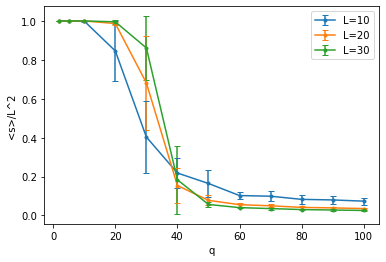

In [9]:
#collapse
for i in range(Lv.size):
    plt.errorbar(Qrange,magv[i].mean(axis=1),yerr=magv[i].std(axis=1), label="L="+str(Lv[i]), marker='.')
    plt.xlabel('Q')
    plt.ylabel('$⟨s_{max}⟩$')
    
plt.legend()
plt.show()

Dal grafico precedente possiamo notare la presenza di una transizione di fase, infatti a bassi valori di $Q$ corrispondono valori di $⟨s_{max}⟩$ pressoché unitari mentre per grandi valori $Q$ $⟨s_{max}⟩$ tende a zero. Queste due fasi sono separate da una graduale diminuzione che diventa sempre più accentata aumentando la taglia del sistema, lasciando immaginare che nel limite termodinamico $N\to0$ il sistema presenti una discontinuità nel valore di $⟨s_{max}⟩$ e quindi una transizione di fase di seconda specie come quello della transizione ferromagnetica. Si può stimare il punto critico in corrispondenza di un valore di $Q$ compreso tra 30 e 40.

# Studio dei tempi critici

Un altro parametro interessante, sempre relativo agli stati finali, è il tempo che ci impiega in media un sistema a raggiungere uno stato Absorbing, detto tempo critico $t_c$, anche in questo caso infatti si possono notare gli effetti di una transizione di fase:

In [ ]:
#collapse


Lv=np.array([10,15,20,25,30])
D=2

F=10

TN=100000

rep=30

Qrange=np.array([5,10,20,30,40,60,80,100])
#magv=np.zeros((Lv.size,Qrange.size,rep))
TCv=np.zeros((Lv.size,Qrange.size,rep))
nA=np.zeros((Lv.size,Qrange.size,TN,rep))

ll=0

for L in Lv:
    N=L**D
    
    for rip in range(rep):
        q=0
        
        for Q in Qrange:

            TC=TN-1
            ind=iniState(N,F,Q)
            indt=np.zeros((N,F),dtype=int)
            mag=0

            for tnn in np.arange(TN):
                indt=ind.copy()
                
                for tn in np.arange(N):
                    
                    # Elementary Step
                    
                    a=np.random.randint(N)
                    b=chooseBlat(a)

                    if (indt[a]!=indt[b]).any() and (indt[a]==indt[b]).any():
                        c=np.random.randint(F)
                        
                        if indt[a,c]==indt[b,c]:
                            dd=np.random.randint(F)
                            
                            for Fi in range(F):
                                d=(dd+Fi)%F
                                
                                if indt[a,d]!=indt[b,d]:
                                    indt[a,d]=indt[b,d].copy()
                                    break
                                    
                ind=indt.copy()
                                    
                nA[ll,q,tnn,rip]=calcAct(ind)

                if nA[ll,q,tnn,rip]==0:
                    TC=tnn
                    break                

                #print('{}\r'.format(tnn), end="")

                
            #magv[ll,q,rip]=calcMag(ind)
            TCv[ll,q,rip]=TC
            q+=1
            
    #print('{}\r'.format(L), end="")
    ll+=1
    
#print()



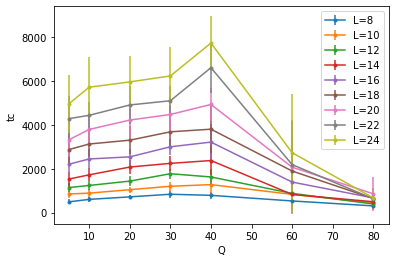

In [74]:
#collapse

# con i parametri del codice di sotto
for ll in range(0,Lv.size,2):          # ancora da far girare, ne servono di meno cmq 
    TCM=int(np.amax(TCv[ll]))
    plt.errorbar(Qrange,TCv[ll].mean(axis=1),yerr=TCv[ll].std(axis=1), label="L="+str(Lv[ll]),marker=".")
    #plt.plot(Qrange,nA[0,Q].mean(axis=1)[:TCM])
    plt.xlabel('Q')
    plt.ylabel('$t_c$')
    #plt.xscale("log")
    
plt.legend()
    
#plt.plot(range(TC),nA[:TC]/N)
#plt.xscale("log")
plt.show()

Dal grafico precedente possiamo notare che il tempo critico corrispondente a valori di $Q$ subcritici tende ad aumentare al crescere della taglia del sistema, presentando un picco proprio intorno a $Q_c$, al di sopra inceve $t_c$ **tende a zero** a prescindere dalla taglia del sistema.

Per studiare questo comportamento andiamo a graficare i tempi critici questa volta in funzione di $L$:

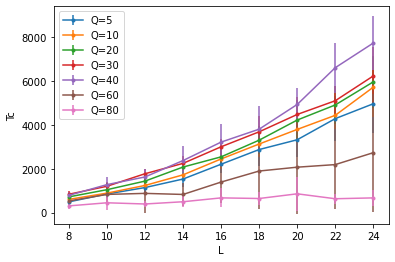

In [12]:
#collapse
for Q in range(Qrange.size):
    plt.errorbar(Lv,TCv[:,Q].mean(axis=1),yerr=TCv[:,Q].std(axis=1), marker='.', label="Q="+str(Qrange[Q]))
    plt.xlabel('L')
    plt.ylabel('Tc')
    #plt.xscale("log")
    #plt.yscale("log")

plt.legend()
plt.show()

Come possiamo notare dal grafico precedente per valori $Q$ supercrici $t_c$ sembra diminuire la sua crescita fino a rimanere pressoché costante al variare di $L$.

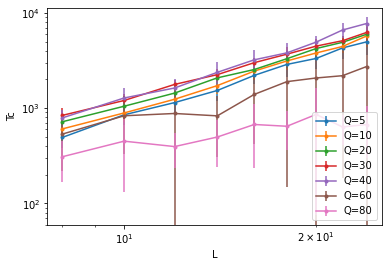

In [13]:
#collapse
for Q in range(Qrange.size):
    plt.errorbar(Lv,TCv[:,Q].mean(axis=1),yerr=TCv[:,Q].std(axis=1), marker='.', label="Q="+str(Qrange[Q]))
    plt.xlabel('L')
    plt.ylabel('Tc')
    plt.xscale("log")
    plt.yscale("log")

plt.legend()
plt.show()

Q = 5: Fit Slop = 2.0982423722444743
Q = 10: Fit Slop = 2.0616719408001645
Q = 20: Fit Slop = 1.9471721662831847
Q = 30: Fit Slop = 1.8299025446394042
Q = 40: Fit Slop = 2.069247222465267
Q = 60: Fit Slop = 1.4671073272337474
Q = 80: Fit Slop = 0.7674905225381033


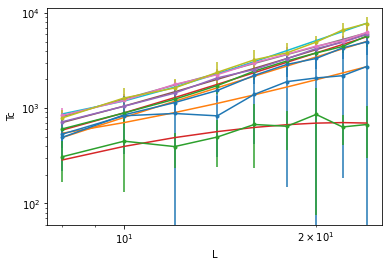

In [76]:
#collapse
for Q in range(Qrange.size):
    plt.errorbar(Lv,TCv[:,Q].mean(axis=1),yerr=TCv[:,Q].std(axis=1), marker='.', label="Q="+str(Qrange[Q]))
    plt.plot(Lv,np.polyfit(Lv,TCv[:,Q].mean(axis=1),2)[0]*Lv**2+np.polyfit(Lv,TCv[:,Q].mean(axis=1),2)[1]*Lv+np.polyfit(Lv,TCv[:,Q].mean(axis=1),2)[2])
    plt.xlabel('L')
    plt.ylabel('Tc')
    plt.xscale("log")
    plt.yscale("log")
    
    print("Q = " + str(Qrange[Q]) +": Fit Slop = " + str(np.polyfit(np.log(Lv),np.log(TCv[:,Q].mean(axis=1)),1)[0]))

#plt.legend()
plt.show()


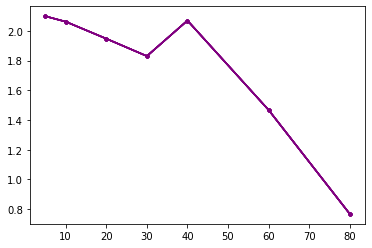

In [68]:
#collapse
for Q in range(Qrange.size):
    plt.plot(Qrange,np.polyfit(np.log(Lv),np.log(TCv[:].mean(axis=2)),1)[0],marker=".",color="Purple")


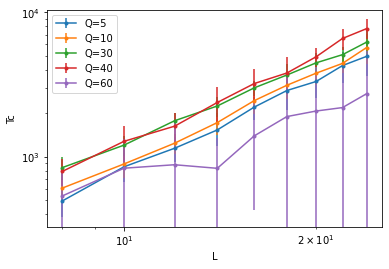

In [15]:
#collapse
for Q in np.array([0,1,3,4,5]):
    plt.errorbar(Lv,TCv[:,Q].mean(axis=1),yerr=TCv[:,Q].std(axis=1), marker='.', label="Q="+str(Qrange[Q]))
    plt.xlabel('L')
    plt.ylabel('Tc')
    plt.xscale("log")
    plt.yscale("log")

plt.legend()
plt.show()

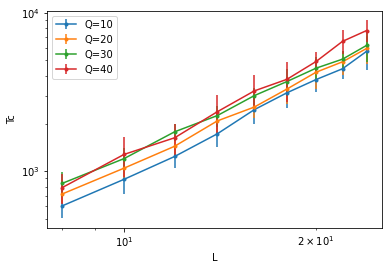

In [17]:
#collapse
for Q in np.array([1,2,3,4]):
    plt.errorbar(Lv,TCv[:,Q].mean(axis=1),yerr=TCv[:,Q].std(axis=1), marker='.', label="Q="+str(Qrange[Q]))
    plt.xlabel('L')
    plt.ylabel('Tc')
    plt.xscale("log")
    plt.yscale("log")

plt.legend()
plt.show()

Q = 20: Fit Slop = 1.9471721662831847
Q = 30: Fit Slop = 1.8299025446394042
Q = 40: Fit Slop = 2.069247222465267


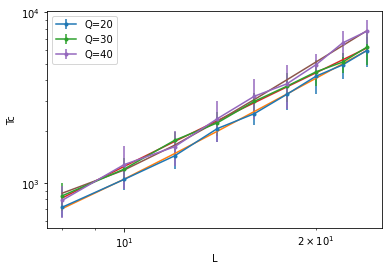

In [71]:
#collapse
for Q in np.array([2,3,4]):
    plt.errorbar(Lv,TCv[:,Q].mean(axis=1),yerr=TCv[:,Q].std(axis=1), marker='.', label="Q="+str(Qrange[Q]))
    plt.plot(Lv,np.polyfit(Lv,TCv[:,Q].mean(axis=1),2)[0]*Lv**2+np.polyfit(Lv,TCv[:,Q].mean(axis=1),2)[1]*Lv+np.polyfit(Lv,TCv[:,Q].mean(axis=1),2)[2])
    plt.xlabel('L')
    plt.ylabel('Tc')
    plt.xscale("log")
    plt.yscale("log")
    
    print("Q = " + str(Qrange[Q]) +": Fit Slop = " + str(np.polyfit(np.log(Lv),np.log(TCv[:,Q].mean(axis=1)),1)[0]))

plt.legend()
plt.show()


Q = 20: Fit Slop = 1.9471721662831847


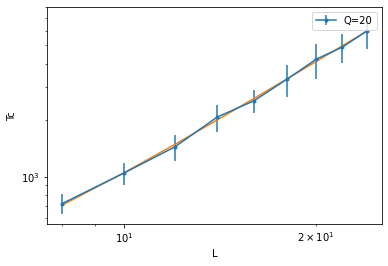

In [70]:
#collapse
for Q in np.array([2]):
    plt.errorbar(Lv,TCv[:,Q].mean(axis=1),yerr=TCv[:,Q].std(axis=1), marker='.', label="Q="+str(Qrange[Q]))
    plt.plot(Lv,np.polyfit(Lv,TCv[:,Q].mean(axis=1),2)[0]*Lv**2+np.polyfit(Lv,TCv[:,Q].mean(axis=1),2)[1]*Lv+np.polyfit(Lv,TCv[:,Q].mean(axis=1),2)[2])
    plt.xlabel('L')
    plt.ylabel('Tc')
    plt.xscale("log")
    plt.yscale("log")
    
    print("Q = " + str(Qrange[Q]) +": Fit Slop = " + str(np.polyfit(np.log(Lv),np.log(TCv[:,Q].mean(axis=1)),1)[0]))

plt.legend()
plt.show()


# Studio della dinamica 

Fino a questo punto ci siamo occupati dello studio degli stati finali, al termine dell'evoluzione dinamica. Ora passiamo invece allo studio della dinamica stessa. In questo caso il parametro d'ordine che considereremo è la densità di collegamenti attivi $n_A$, definiti come prima, calcolata attraverso la funzione *calcAct*. Questa grandezza caratterizza lo stato della dinamica e risulta nulla in una configurazione Absorbing. In realtà questa proprietà è stata usata finora come criterio di arresto dell'algoritmo, che veniva bloccato una volta che $n_A$ risultava uguale a zero.

Il comportamento di $n_A$ al variare del tempo è una delle caratteristiche che rende questo modello ben distinto dal Voter Model, sua controparte scalare, ed interessante perchè emergente proprio dalla generalizzazione al caso vettoriale, producendo una fenomenologia nuova e non banale.

Il codice sottostante restituisce il grafico dell'andamanento di $n_A$ nel tempo per alcuni diversi valori di $Q$, per $L=10$ ed $F=8$:

29


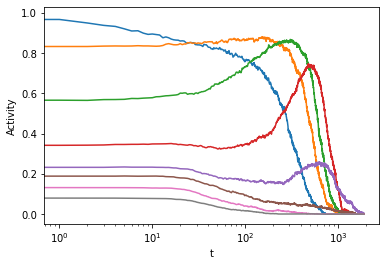

In [13]:
#collapse
#%%time

Lv=np.array([10])
D=2
F=8

TN=100000

rep=30

Qrange=np.array([2,5,10,20,30,40,60,100])
qrange=np.arange(Qrange.size)
magv=np.zeros((Lv.size,Qrange.size,rep))
TCv=np.zeros((Lv.size,Qrange.size,rep))
nA=np.zeros((Lv.size,Qrange.size,TN,rep))

ll=0
for L in Lv:
    N=L**D
    
    for rip in range(rep):
        q=0
        
        for Q in Qrange:

            TC=TN-1
            ind=iniState(N,F,Q)
            indt=np.zeros((N,F),dtype=int)
            mag=0

            for tnn in np.arange(TN):
                indt=ind.copy()
                
                for tn in np.arange(N):
                    a=np.random.randint(N)
                    b=chooseBlat(a)

                    if (indt[a]!=indt[b]).any() and (indt[a]==indt[b]).any():
                        c=np.random.randint(F)
                        if indt[a,c]==indt[b,c]:
                            dd=np.random.randint(F)
                            for Fi in range(F):
                                d=(dd+Fi)%F
                                if indt[a,d]!=indt[b,d]:
                                    indt[a,d]=indt[b,d].copy()
                                    break
                                    
                ind=indt.copy()
                                    
                nA[ll,q,tnn,rip]=calcAct(ind)
                
                mag=calcMag(ind)  # magnetization

                if nA[ll,q,tnn,rip]==0:
                    TC=tnn
                    break                

                #print('{}\r'.format(tnn), end="")

                
            magv[ll,q,rip]=np.amax(mag)
            TCv[ll,q,rip]=TC
            q+=1
            
        print('{}\r'.format(rip), end="")
    ll+=1
    
print()

# fig only for L=20 

TCM=int(np.amax(TCv[0]))
for Q in range(Qrange.size):
    #plt.errorbar(range(TCM),nA[Q].mean(axis=1)[:TCM],yerr=nA[Q].std(axis=1)[:TCM], label="Q="+str(Qrange[Q]))
    plt.plot(range(TCM),nA[0,Q].mean(axis=1)[:TCM])
    plt.xlabel('t')
    plt.ylabel('Activity')
    plt.xscale("log")
    
#plt.legend()
    
#plt.plot(range(TC),nA[:TC]/N)
#plt.xscale("log")
plt.show()

Come possiamo notare dal grafico precedente, per **bassi** valori di $Q$ il sistema presenta una lenta diminuzione di $n_A$, con la maggior parte dei collegamenti tra individui attivi, per poi diminuire più rapidamente per tempi lungi e raggiungere uno stato Absorbing, come abbiamo visto, in un tempo proporzionale al numero di elementi che costituiscono il sistema. Per grandi valori di $Q$ dopo un breve periodo transiente iniziale $n_A$ diminuisce velocemente e raggiunge uno stato Absorbing in un tempo finito.

Il comportamento interessante avviene per valori intermedi di $Q$ in cui si ha una diminuzione iniziale dei collegamenti attivi, un aumento verso un picco di attività e poi una diminuzione finale che finisce col raggiungimento di un Absorbing State. 

La dinamica è essenzialmente un processo di formazione ed ingrandimento di cluster di individui che condividono gli stessi valori di features. Per $Q<Q_c$ il processo va avanti per tempi dell'ordine di $N=L^2$ e tende a creare cluster di dimensione comparabile a quella del sistema, mentre per $Q>Q_c$ il processo crea cluster di dimensione finita in un tempo finito.


Questo comportamento non monotono evidenziato nei grafici precedenti è caratteristico del modello di Axelrod e nella prossima sezione andremo a studiarlo attraverso un approccio analitico.

24


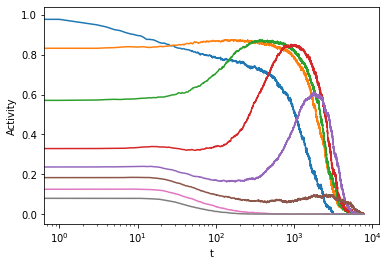

CPU times: user 6h 48min 55s, sys: 14.1 s, total: 6h 49min 9s
Wall time: 6h 49min 6s


In [54]:
#collapse
%%time

Lv=np.array([10,15,20])
D=2
F=8

TN=100000

rep=25

Qrange=np.array([2,5,10,20,30,40,60,100])
qrange=np.arange(Qrange.size)
magv=np.zeros((Lv.size,Qrange.size,rep))
TCv=np.zeros((Lv.size,Qrange.size,rep))
nA=np.zeros((Lv.size,Qrange.size,TN,rep))

ll=0
for L in Lv:
    N=L**D
    for rip in range(rep):
        q=0
        for Q in Qrange:

            TC=TN-1
            ind=np.zeros((N,F),dtype=int)
            ind=iniState(N,F,Q)
            indt=np.zeros((N,F),dtype=int)
            mag=0
            
            

            for tnn in np.arange(TN):
                Act=np.zeros((D*N,2),dtype=int)-1
                for ai in range(N):
                    bi=Bdx(ai)
                    if (ind[ai]==ind[bi]).any() and (ind[ai]!=ind[bi]).any():
                        Act[D*ai]=np.array([ai,bi])

                    ci=Bdw(ai)
                    if(ind[ai]==ind[ci]).any() and (ind[ai]!=ind[ci]).any():
                        Act[D*ai+1]=np.array([ai,ci])
                        
                nA[ll,q,tnn,rip]=(Act[:,0]+1).nonzero()[0].size/N/2

                
                if nA[ll,q,tnn,rip]==0:
                    TC=tnn
                    break
                
                mag=calcMag(ind)  # magnetization
                
                
                indt=ind.copy()
                for tn in np.arange(N):
                    a=np.random.randint(N)
                    b=chooseBlat(a)

                    if (indt[a]!=indt[b]).any() and (indt[a]==indt[b]).any():
                        c=np.random.randint(F)
                        if indt[a,c]==indt[b,c]:
                            dd=np.random.randint(F)
                            for Fi in range(F):
                                d=(dd+Fi)%F
                                if indt[a,d]!=indt[b,d]:
                                    indt[a,d]=indt[b,d].copy()
                                    break

                ind=indt.copy()
                
                #print('{}\r'.format(tnn), end="")

                
            magv[ll,q,rip]=np.amax(mag)
            TCv[ll,q,rip]=TC
            q+=1
            
        print('{}\r'.format(rip), end="")
    ll+=1
    
print()

# fig only for L=20 

TCM=int(np.amax(TCv[2]))
for Q in range(Qrange.size):
    #plt.errorbar(range(TCM),nA[Q].mean(axis=1)[:TCM],yerr=nA[Q].std(axis=1)[:TCM], label="Q="+str(Qrange[Q]))
    plt.plot(range(TCM),nA[2,Q].mean(axis=1)[:TCM])
    plt.xlabel('t')
    plt.ylabel('Activity')
    plt.xscale("log")
    
#plt.legend()
    
#plt.plot(range(TC),nA[:TC]/N)
#plt.xscale("log")
plt.show()

29


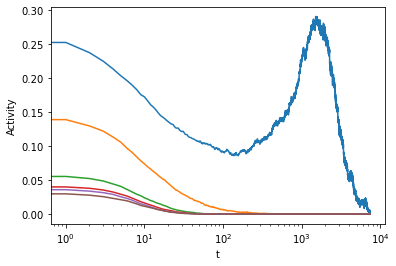

In [89]:
#collapse

Lv=np.array([21])
D=2
F=3

TN=100000

rep=30

Qrange=np.array([10,20,50,70,79,100])
qrange=np.arange(Qrange.size)
magv=np.zeros((Lv.size,Qrange.size,rep))
TCv=np.zeros((Lv.size,Qrange.size,rep))
nA=np.zeros((Lv.size,Qrange.size,TN,rep))

ll=0
for L in Lv:
    N=L**D
    for rip in range(rep):
        q=0
        for Q in Qrange:

            TC=TN-1
            ind=np.zeros((N,F),dtype=int)
            ind=iniState(N,F,Q)
            indt=np.zeros((N,F),dtype=int)
            mag=0
            
            

            for tnn in np.arange(TN):
                Act=np.zeros((D*N,2),dtype=int)-1
                for ai in range(N):
                    bi=Bdx(ai)
                    if (ind[ai]==ind[bi]).any() and (ind[ai]!=ind[bi]).any():
                        Act[D*ai]=np.array([ai,bi])

                    ci=Bdw(ai)
                    if(ind[ai]==ind[ci]).any() and (ind[ai]!=ind[ci]).any():
                        Act[D*ai+1]=np.array([ai,ci])
                        
                nA[ll,q,tnn,rip]=(Act[:,0]+1).nonzero()[0].size/N/2

                
                if nA[ll,q,tnn,rip]==0:
                    TC=tnn
                    break
                
                mag=calcMag(ind)  # magnetization
                
                
                indt=ind.copy()
                for tn in np.arange(N):
                    a=np.random.randint(N)
                    b=chooseBlat(a)

                    if (indt[a]!=indt[b]).any() and (indt[a]==indt[b]).any():
                        c=np.random.randint(F)
                        if indt[a,c]==indt[b,c]:
                            dd=np.random.randint(F)
                            for Fi in range(F):
                                d=(dd+Fi)%F
                                if indt[a,d]!=indt[b,d]:
                                    indt[a,d]=indt[b,d].copy()
                                    break

                ind=indt.copy()
                
                #print('{}\r'.format(tnn), end="")

                
            magv[ll,q,rip]=np.amax(mag)
            TCv[ll,q,rip]=TC
            q+=1
            
        print('{}\r'.format(rip), end="")
    ll+=1
    
print()

# fig only for L=20 

TCM=int(np.amax(TCv[0]))
for Q in range(Qrange.size):
    #plt.errorbar(range(TCM),nA[Q].mean(axis=1)[:TCM],yerr=nA[Q].std(axis=1)[:TCM], label="Q="+str(Qrange[Q]))
    plt.plot(range(TCM),nA[0,Q].mean(axis=1)[:TCM])
    plt.xlabel('t')
    plt.ylabel('Activity')
    plt.xscale("log")
    
#plt.legend()
    
#plt.plot(range(TC),nA[:TC]/N)
#plt.xscale("log")
plt.show()

# Master Equation

Il comportamento dinamico del modello può essere studiato attraverso l'analisi di un singolo collegamento in approssimazione di campo medio. 

Dato un collegamento tra due elementi primi vicini scelti casualmente, il collegamento si dice di tipo $m$ se i due individui hanno in comune $m$ features e $F-m$ features differenti.
Si definisce $P_m(t)$ la probabilità che un collegamento scelto a caso sia di tipo $m$ al tempo $t$.
Al tempo $t=0$ poichè i valori delle features sono estratte a caso, la probabilità che il collegamento sia di tipo $m$ è data dalla distribuzione binomiale $P_m(0)= \binom{F}{m} \rho_0^m(1-\rho_0)^{F-m}$ con $\rho_0=$Prob$[q_{i,f}=q_{j,f}]$, che, poichè al tempo $t=0$ i valori delle features sono estratti da una distribuzione uniforme segue che $\rho_0=1/Q$.

In approssimazione di campo medio la master equation risulta essere:

$$\frac{d P_m}{dt}=\sum_{k=1}^{F-1} \frac{k}{F} P_k [ \delta_{m,k+1}-\delta_{m,k}+(g-1)\sum_{n=0}^F (P_n W_{n,m}^{(k)}-P_m W_{m,n}^{(k)}) ] $$

dove è sottintesa la dipendenza delle probabilità dal tempo $t$. $g$ è il numero di coordinazione del reticolo, nel nostro caso 2D, $g=4$ e $W_{n,m}^{(k)}$ è la probabilità di transizione di un collegamento dal tipo $n$ ad uno $m$, dovuto al cambiamento di un collegamento vicino di tipo $k$.

Questa equazione descrive come il numero di collegamenti di tipo $m$ vari in funzione dalla dinamica: $\frac{k}{F} P_k$ è la probabilità di scegliere un collegamento di tipo $k$ e di selezionare una delle $k$ features che i due individui condividono. **Se $k=m-1$ viene creato un nuovo collegamento di tipo $m$, se invece $k=m$ un collegamento di tipo $m$ viene distrutto.** Questo spiega i primi due termini della parentesi quadra nell'equazione precedente. I termini restanti prendono invece in considerazione il cambiamento dei tipi degli altri $(g-1)$ collegamenti del sito in esame con gli altri primi vicini.

Per calcolare le probabilità di transizione $W_{n,m}^{(k)}$ è necessario analizzare in dettaglio ogni processo possibile. Per mostrare come sono stati calcolati i valori di $W$ consideriamo ad esempio un collegamento di tipo $k=1$ adiacente ad uno di tipo $n=0$. Senza perdere di generalità ipotizziamo che gli individui $i$ e $j$ agli estremi del collegamento $k=1$ abbiano rispettivamente i valori delle features: $(0,0,...,0)$ e $(0,q_2,...,q_F)$ con $q_j\neq0$ $ \forall j$. Il terzo sito $l$, primo vicino di $j$, non condividendo con $j$ nessuna feature (collegamento di tipo $n=0$) possiede i seguenti valori delle features: $(q_1',q_2',...,q_F')$ con $q_1'\neq0$ e $q_j'\neq q_j$ $\forall j>1$. Quando $k$ da tipo $1$ diventa tipo $2$, immaginiamo per esempio che $q_2 \to 0$, l'altro collegamento $n$ adiacente può diventare un collegamento di tipo $1$ se $q_2'=0$ oppure rimanere $0$ se $q_2'\neq0$. Nello spirito dell'approssimazione di campo medio introduciamo la probabilità $\rho =$Prob$(q_2'=0)$ che considereremo dipendente dal tempo. Quindi nel nostro esempio risulterebbero $W_{0,1}^{(1)}=\rho$ e $W_{0,0}^{(1)}=1-\rho$.

Attraverso questo metodo sono andato a calcolare le altre probabilità di transizione per il caso $F=3$. Poichè nel caso in cui $i$ e $j$ non abbiano features in comune o ce le abbiano tutte uguali non avviene una dinamica, il collegamento $n$ non ha probabilità di transizione quindi $ W^{(0)}_{n,m}=W^{(0)}_{m,n}=0\quad \forall m,n$ e nella stessa maniera $W^{(3)}_{n,m}=W^{(3)}_{m,n}=0$. Inoltre calcolando i valori di per tutti i casi possibili ho notato che $W^{(1)}_{n,m}=W^{(2)}_{n,m}\quad\forall m,n$ quindi eviterò di riportare gli apici nel seguito, ritenendo il valore di $W$ uguale sia nel caso $k=1$ che nel caso $k=2$:

$$W_{0,0}=1-\rho \quad  \quad W_{0,1}=\rho$$
$$W_{1,0}=\frac{1}{3} \quad  \quad W_{1,1}=\frac{2}{3}(1-\rho) \quad  \quad W_{1,2}=\frac{2}{3} \rho$$
$$W_{2,1}=\frac{2}{3} \quad  \quad W_{2,2}=\frac{1}{3}(1-\rho) \quad  \quad W_{2,3}=\frac{1}{3} \rho$$
$$W_{3,2}=0 \quad  \quad W_{3,3}=1$$

Per tutti gli altri valori di $n$ ed $m$ $W_{n,m}=0$.


Per risolvere la master equation, che in pratica è un sistema di $F+1$ equazioni differenziali ordinarie del primo ordine non lineari accoppiate, non resta che specificare la dinamica di $\rho(t)$. Sempre nello spirito dell'approssimazione di campo medio possiamo scrivere $\rho=\sum_k k P_k/F$, ricordandosi la condizione iniziale $\rho(0)=1/Q$. **Ciò equivale a dire che tra due individui qualsiasi c'è un collegamento, e quindi che la probabilità che una feature abbia lo stesso valore per entrambi gli individui può essere espressa in termini di $P_m$.**

L'integrazione numerica, effettuata attraverso il metodo di Crank–Nicolson, mostra l'andamento della densità di collegamenti attivi calcolata come $n_A(t)=\sum_{k=1}^{F-1}P_k(t)$, da cui risulta un comportamento non monotono del tutto simile a quello evidenziato dalle simulazioni:

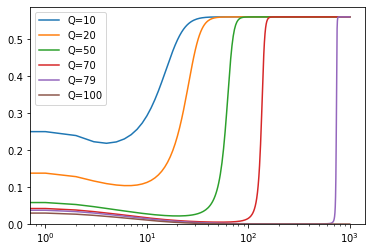

In [82]:
#collapse

F=3
T=1000
P=np.zeros((T+1,F+1))


def W(r):
    W=np.zeros((F+1,F+1))  # n,m
    W[0]=np.array([1-r,r,0,0])
    W[1]=np.array([1/3,(2/3)*(1-r),(2/3)*r,0])
    W[2]=np.array([0,2/3,(1/3)*(1-r),(1/3)*r])
    W[3]=np.array([0,0,1,0])
    return W

def fact(n):
    f=1
    for i in range(1,n+1):
        f*=i
    return f

def CB(n,k):
    return fact(n)/(fact(k)*fact(n-k))

def Prob0(r0):
    P0=np.zeros(F+1)
    for m in range(F+1):
        P0[m]=CB(F,m)*r0**m*(1-r0)**(F-m)
    return P0

def delta(i,j):
    if i==j:
        return 1
    else: return 0
    
    
Qrange=np.array([10,20,50,70,79,100])
    
for Q in Qrange:
    r0=1/Q

    P[0]=Prob0(r0) # initial values, normalized by construction

    for t in range(1):
        r=0
        for k1 in range(F+1):
            r+=k1*P[t,k1]/F
        for m in range(F+1):
            A=np.zeros((2,F+1))

            for k in range(1,F):
                B=0

                for n in range(F+1):

                    B+=(P[t,n]*W(r)[n,m]-P[t,m]*W(r)[m,n])
                A[0]+=P[t,k]*(k/F)*(delta(m,k+1)-delta(m,k)+3*B)
            P[t+1,m]=P[t,m]+A[0,m]
        P[t+1]=P[t+1]/P[t+1].sum()  # normalization



    for t in range(1,T):
        r=0
        for k1 in range(F+1):
            r+=k1*P[t,k1]/F
        for m in range(F+1):
            A[1]=np.zeros(F+1)

            for k in range(1,F):
                B=0

                for n in range(F+1):

                    B+=(P[t,n]*W(r)[n,m]-P[t,m]*W(r)[m,n])
                A[1,m]+=P[t,k]*(k/F)*(delta(m,k+1)-delta(m,k)+3*B)
            P[t+1,m]=P[t,m]+(A[0,m]+A[1,m])/2
        P[t+1]=P[t+1]/P[t+1].sum()  # normalization
        A[0]=A[1].copy()


    nA=np.zeros(T+1)
    for i in range(1,F):
        nA+=P[:,i]

    #for i in range(F+1):
       # plt.plot(range(T+1),P[:,i],label="P("+str(i)+")") 

    plt.plot(range(T+1),nA,label="Q="+str(Q))

    
plt.xscale("log")
plt.ylim(0)
plt.legend()
plt.show()

Come possiamo notare dal grafico sopra per valori di $Q>Q_c$ si osserva una graduale diminuzione di $n_A$ che poi finisce a zero, mentre per $Q<Q_c$ si osserva lo stesso una diminuzione iniziale seguita però da una crescita sempre più ripida per valori di $Q$ che si avvicinano a qullo critico. A differenza dei grafici restituiti dalle simulzioni, per $Q<Q_c$ non si osserva un picco e poi una diminuzione verso zero, ma $n_A$ satura e rimane costante ad un valore finito. Questo fenomeno può essere spiegato ricordandosi che le simulzioni sono state effettuate considerando (per necessità) il numero di individui finito, al contrario nella master equation non ci sono termini che fanno riferimento alla taglia del sistema che viene considerata dunque implicitamente infinita. Possiamo immaginare quindi il sistema in un continuo e costante ingrandimento dei cluster che prosegue indefinitamente.


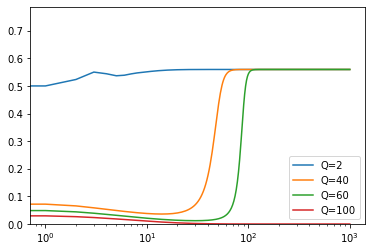

In [88]:
#collapse

F=3
T=1000
P=np.zeros((T+1,F+1))


def W(r):
    W=np.zeros((F+1,F+1))  # n,m
    W[0]=np.array([1-r,r,0,0])
    W[1]=np.array([1/3,(2/3)*(1-r),(2/3)*r,0])
    W[2]=np.array([0,2/3,(1/3)*(1-r),(1/3)*r])
    W[3]=np.array([0,0,1,0])
    return W

def fact(n):
    f=1
    for i in range(1,n+1):
        f*=i
    return f

def CB(n,k):
    return fact(n)/(fact(k)*fact(n-k))

def Prob0(r0):
    P0=np.zeros(F+1)
    for m in range(F+1):
        P0[m]=CB(F,m)*r0**m*(1-r0)**(F-m)
    return P0

def delta(i,j):
    if i==j:
        return 1
    else: return 0
    
    
Qrange=np.array([2,40,60,100])
    
for Q in Qrange:
    r0=1/Q

    P[0]=Prob0(r0) # initial values, normalized by construction

    for t in range(1):
        r=0
        for k1 in range(F+1):
            r+=k1*P[t,k1]/F
        for m in range(F+1):
            A=np.zeros((2,F+1))

            for k in range(1,F):
                B=0

                for n in range(F+1):

                    B+=(P[t,n]*W(r)[n,m]-P[t,m]*W(r)[m,n])
                A[0]+=P[t,k]*(k/F)*(delta(m,k+1)-delta(m,k)+3*B)
            P[t+1,m]=P[t,m]+A[0,m]
        P[t+1]=P[t+1]/P[t+1].sum()  # normalization



    for t in range(1,T):
        r=0
        for k1 in range(F+1):
            r+=k1*P[t,k1]/F
        for m in range(F+1):
            A[1]=np.zeros(F+1)

            for k in range(1,F):
                B=0

                for n in range(F+1):

                    B+=(P[t,n]*W(r)[n,m]-P[t,m]*W(r)[m,n])
                A[1,m]+=P[t,k]*(k/F)*(delta(m,k+1)-delta(m,k)+3*B)
            P[t+1,m]=P[t,m]+(A[0,m]+A[1,m])/2
        P[t+1]=P[t+1]/P[t+1].sum()  # normalization
        A[0]=A[1].copy()


    nA=np.zeros(T+1)
    for i in range(1,F):
        nA+=P[:,i]

    #for i in range(F+1):
       # plt.plot(range(T+1),P[:,i],label="P("+str(i)+")") 

    plt.plot(range(T+1),nA,label="Q="+str(Q))

    
plt.xscale("log")
plt.ylim(0)
plt.legend()
plt.show()

Andando a graficare le probabilità negli gli stati finali della dinamica per diversi valori di $Q$, possiamo anche qua notare una evidente transizione di fase, per esempio per quanto riguarda $n_A$ si può notare una discontinuità per $Q=Q_c$ e lo stesso per $P(0)$ e $P(F)$.

In [ ]:
#collapse

F=3
T=1000
Qmax=10000
P=np.zeros((T+1,F+1))
Pp=np.zeros((Qmax-2,F+1))
nA=np.zeros(Qmax-2)

    
Qrange=np.arange(2,Qmax)
    
for Q in Qrange:
    r0=1/Q

    P[0]=Prob0(r0) # initial values, normalized by construction

    for t in range(1):
        r=0
        for k1 in range(F+1):
            r+=k1*P[t,k1]/F
        for m in range(F+1):
            A=np.zeros((2,F+1))

            for k in range(1,F):
                B=0

                for n in range(F+1):

                    B+=(P[t,n]*W(r)[n,m]-P[t,m]*W(r)[m,n])
                A[0]+=P[t,k]*(k/F)*(delta(m,k+1)-delta(m,k)+3*B)
            P[t+1,m]=P[t,m]+A[0,m]
        P[t+1]=P[t+1]/P[t+1].sum()  # normalization



    for t in range(1,T):
        r=0
        for k1 in range(F+1):
            r+=k1*P[t,k1]/F
        for m in range(F+1):
            A[1]=np.zeros(F+1)

            for k in range(1,F):
                B=0

                for n in range(F+1):

                    B+=(P[t,n]*W(r)[n,m]-P[t,m]*W(r)[m,n])
                A[1,m]+=P[t,k]*(k/F)*(delta(m,k+1)-delta(m,k)+3*B)
            P[t+1,m]=P[t,m]+(A[0,m]+A[1,m])/2
        P[t+1]=P[t+1]/P[t+1].sum()  # normalization
        A[0]=A[1].copy()
 

    Pp[Q-2]=P[T]
    nA[Q-2]=Pp[Q-2,1]+Pp[Q-2,2]

plt.plot(Qrange,nA,label="nA")
plt.plot(Qrange,Pp[:,0],label="P(0)")
plt.plot(Qrange,Pp[:,F],label="P(F+1)")
    
plt.xscale("log")
plt.ylim(0)
plt.legend()
plt.show()

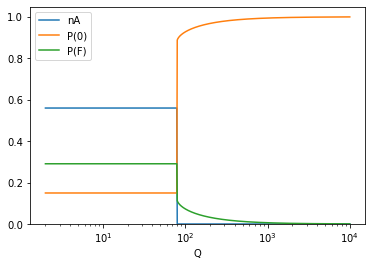

In [362]:
#collapse

plt.plot(Qrange,Pp[:,0],label="P(0)")
plt.plot(Qrange,Pp[:,F],label="P(F)")
plt.plot(Qrange,nA,label="nA")
    
plt.xlabel("Q")
plt.xscale("log")
plt.ylim(0)
plt.legend()
plt.show()

# Conclusioni 

# Bibliografia

Axelrod, R., 1997, J. Conﬂict Resolut. 41(2), 203.

C. Castellano, M. Marsili, and A. Vespignani, 2000, Phys. Rev. Lett. 85(16), 3536.

C. Castellano, S. Fortunato and V. Loreto, “Statistical Physics of Social Dynamics, Rev. Mod. Phys. 81, 591 (2009).